In [25]:
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import collections as c
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)

In [26]:
log_reg_model = pickle.load(open('logistic_regression_completion_first_half.p', 'rb')) # load the model

In [27]:
log_reg_model.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=1e-05, verbose=0, warm_start='False')>

In [57]:
def scale_subset(df, columns):
    '''
    Use sklearn StandardScalar to scale only numeric columns.

    Parameters:
    ----------
    input {dataframe, list}: dataframe containing mixed feature variable types, list of names of numeric feature columns
    output: {dataframe}: dataframe with numeric features scaled and categorical features unchanged

    '''
    scalar = StandardScaler()
    numeric = df[columns]
    categorical = df.drop(columns, axis = 1)
    scalar.fit(numeric)
    num_scaled = pd.DataFrame(scalar.transform(numeric))
    num_scaled.rename(columns = dict(zip(num_scaled.columns, numeric_cols)), inplace = True)
    return pd.concat([num_scaled, categorical], axis = 1)

def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label='Logistic Regression', 
         color='red')
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()


In [29]:
# X_train = pd.read_csv('../data/processed/first_half/X_train.csv')
# y_train = pd.read_csv('../data/processed/first_half/y_train.csv')
# y_train = y_train['module_not_completed']
X_test = pd.read_csv('../data/processed/first_half/X_test.csv')

y_test = pd.read_csv('../data/processed/first_half/y_test.csv')
y_test = y_test['module_not_completed']

numeric_cols = ['num_of_prev_attempts', 'studied_credits', 'module_presentation_length', 'sum_click_dataplus', 'sum_click_dualpane', 'sum_click_externalquiz', 'sum_click_forumng','sum_click_glossary', 'sum_click_homepage', 'sum_click_htmlactivity', 'sum_click_oucollaborate', 'sum_click_oucontent', 'sum_click_ouelluminate', 'sum_click_ouwiki', 'sum_click_page', 'sum_click_questionnaire', 'sum_click_quiz', 'sum_click_repeatactivity', 'sum_click_resource', 'sum_click_sharedsubpage', 'sum_click_subpage', 'sum_click_url', 'sum_days_vle_accessed', 'max_clicks_one_day', 'first_date_vle_accessed', 'avg_score', 'avg_days_sub_early', 'days_early_first_assessment', 'score_first_assessment']

# fill and scale
# X_train.fillna(value = 0, inplace = True)
# X_train = scale_subset(X_train, numeric_cols)
X_test.fillna(value = 0, inplace = True)
X_test = scale_subset(X_test, numeric_cols)

high_vif = ['module_presentation_length', 'sum_days_vle_accessed', 'score_first_assessment', 'days_early_first_assessment']
# X_train.drop(high_vif, axis = 1, inplace = True)
X_test.drop(high_vif, axis = 1, inplace = True)

/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [59]:
t = 0.4

In [60]:
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = log_reg_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions)
    class_report = classification_report(y_test, predictions)

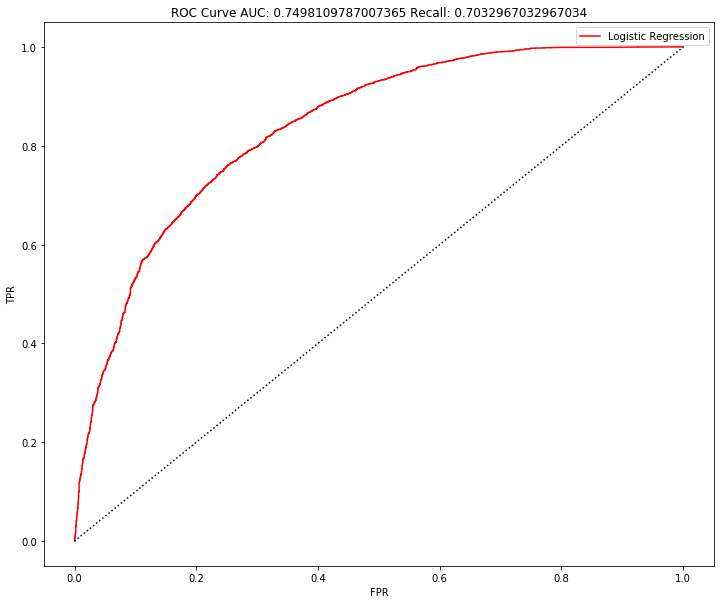

Best Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=1e-05, verbose=0, warm_start='False')

Roc Auc: 0.7498109787007365

Recall Score: 0.7032967032967034

Classification Report at Threshold 0.4:
               precision    recall  f1-score   support

       False       0.82      0.80      0.81      5116
        True       0.67      0.70      0.69      3003

   micro avg       0.76      0.76      0.76      8119
   macro avg       0.75      0.75      0.75      8119
weighted avg       0.76      0.76      0.76      8119


Confusion Matrix at Threshold 0.4:
 [[2112 1042]
 [ 891 4074]]


In [61]:
    print_roc_curve(y_test, probas)
    print('Best Model: {}'.format(log_reg_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))

In [63]:
    # Feature Importances
    abs_coef = list(np.abs(log_reg_model.coef_.ravel()))
    features = list(X_test.columns)
    coef_dict = c.OrderedDict((zip(abs_coef, features)))
    print('The top ten features affecting completion are:\n')
    sorted(coef_dict.items(), reverse=True)[:10]

The top ten features affecting completion are:



[(1.3592540035912402, 'avg_score'),
 (1.0766723397761364, 'code_module_FFF'),
 (0.9506949425582728, 'code_module_CCC'),
 (0.8598306856392018, 'code_module_EEE'),
 (0.8335510440095666, 'code_module_DDD'),
 (0.8229766584673477, 'imd_band_nan'),
 (0.7280808568221493, 'code_module_GGG'),
 (0.6186816757568895, 'sum_click_oucontent'),
 (0.5914163001849582, 'highest_education_No Formal quals'),
 (0.5123673482803173, 'highest_education_Lower Than A Level')]

In [64]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[800:3487:100]

,fprs,tprs,Thresholds
800,0.153846,0.635457,0.731065
900,0.180486,0.670641,0.708575
1000,0.202797,0.702502,0.686235
1100,0.229104,0.732213,0.661978
1200,0.252414,0.761142,0.635011
1300,0.283383,0.787725,0.609290
1400,0.312354,0.810985,0.584170
1500,0.339660,0.834636,0.559915
1600,0.371295,0.855942,0.531221
1700,0.400266,0.879789,0.495401
